In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import pickle as pkl

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from mtt.data import OnlineDataset
from mtt.models import load_model, Conv2dCoder
from mtt.peaks import find_peaks
from mtt.utils import ospa, gaussian, make_grid
from mtt.simulator import Simulator
from mtt.phd import phd_filter, positions_from_phd

rng = np.random.default_rng()
sns.set_theme("paper", "ticks", font_scale=1.5)  # type: ignore

In [3]:
scale = 1


def init_simulator():
    return Simulator(window=1000 * scale)


online_dataset = OnlineDataset(
    n_steps=119,
    sigma_position=10,
    length=20,
    img_size=scale * 128,
    device="cuda",
    init_simulator=init_simulator,
)
with open(f"../data/test/{scale}km/simulations.pkl", "rb") as f:
    dataset_vectors = pkl.load(f)

dataset_idx = 42
images = map(online_dataset.vectors_to_images, *zip(*dataset_vectors[dataset_idx]))
stacked = list(online_dataset.stack_images(images))


In [4]:
simulator = dataset_vectors[0][0][4]
window = simulator.window
extent = [-window / 2, window / 2, -window / 2, window / 2]
n_detections = (
    simulator.n_sensors * np.pi * simulator.sensors[0].range_max ** 2 / 1000**2
)

In [5]:
# Make CNN Predictions
model = load_model(Conv2dCoder, "111662c9")
x = torch.stack([d[0] for d in stacked], dim=0)
with torch.no_grad():
    pred_img = model(x.cuda()).cpu().numpy()

n = pred_img.shape[0]
filt_idx = -1

width = online_dataset.init_simulator().width
window = online_dataset.init_simulator().window
extent = [-window / 2, window / 2, -window / 2, window / 2]

predictions_cnn = []
for i in range(n):
    predictions_cnn.append(find_peaks(pred_img[i][filt_idx], width=window)[0])

In [6]:
with open(f"../data/test/{scale}km/phd.pkl", "rb") as f:
    dataset_phd = pkl.load(f)
phd = dataset_phd[dataset_idx][online_dataset.length-1:]
predictions_phd = []
for i in range(n):
    predictions_phd.append(positions_from_phd(phd[i], n_detections))

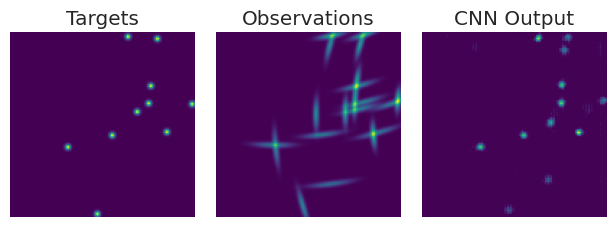

In [7]:
idx = 10
fig, axs = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower", cmap="viridis")
axs[0].set_title("Targets")
axs[1].imshow(stacked[idx][0][filt_idx].cpu(), extent=extent, origin="lower", cmap="viridis")
axs[1].set_title("Observations")
axs[2].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower", cmap="viridis")
axs[2].set_title("CNN Output")
for ax in axs:
    ax.axis("off")
plt.savefig("../figures/images.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

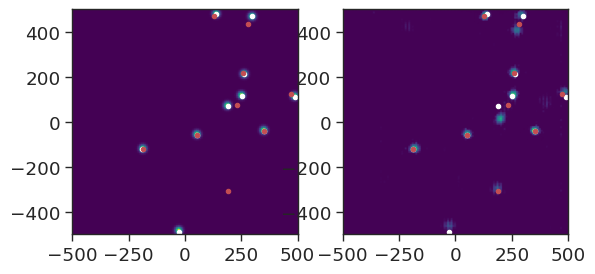

In [8]:
idx = 10
fig, axs = plt.subplots(1, 2)
target_pos = stacked[idx][2][filt_idx]["target_positions"]
mu, *_ = find_peaks(pred_img[idx][filt_idx], width=window)

axs[0].imshow(stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower", cmap="viridis")
axs[1].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower", cmap="viridis")
for ax in axs:
    ax.scatter(*target_pos.T, c="w", s=10)
    ax.scatter(*mu.T, c="r", s=10)
    ax.set_xlim(-window / 2, window / 2)
    ax.set_ylim(-window / 2, window / 2)
plt.show()


In [9]:
mean_energy = np.mean([pos_img[1].cpu().sum(dim=[-1,-2]) for _, pos_img, _ in stacked])
mean_cardinality = np.mean([len(info["target_positions"]) for _,_,infos in stacked for info in infos])
mean_energy, mean_cardinality

(8.19769, 8.3605)

In [10]:
card_true = np.array([len(d[2][filt_idx]["target_positions"]) for d in stacked])
card_cnn = np.array([len(p) for p in predictions_cnn])
card_phd = np.array([len(p) for p in predictions_phd])

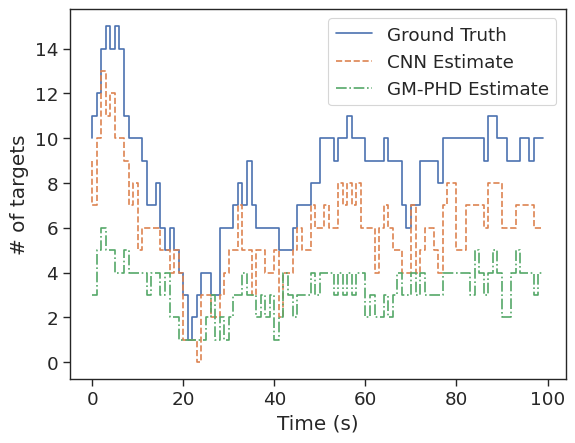

In [11]:
# plot cardinality
plt.step(np.arange(n), card_true, label="Ground Truth")
plt.step(np.arange(n), card_cnn, label="CNN Estimate", linestyle="dashed")
plt.step(np.arange(n), card_phd, label="GM-PHD Estimate", linestyle="dashdot")
plt.xlabel("Time (s)")
plt.ylabel("# of targets")
plt.legend()
plt.savefig("../figures/cardinality.pdf")

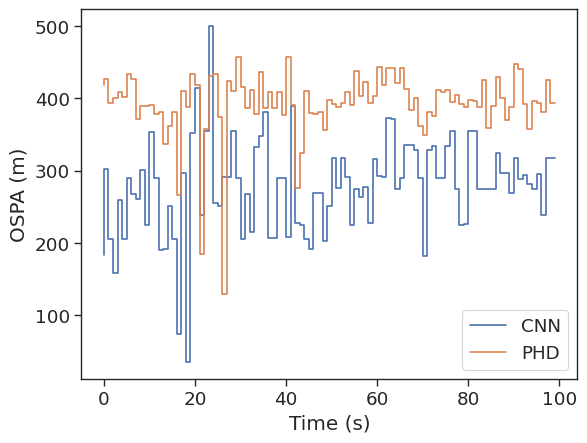

In [12]:
ospa_cnn = []
ospa_phd = []
for idx in range(n):
    sensor_img, target_img, info = stacked[idx]
    target_positions = info[-1]["target_positions"]
    ospa_cnn += [ospa(target_positions, predictions_cnn[idx], 500)]
    ospa_phd += [ospa(target_positions, predictions_phd[idx], 500)]

plt.figure()
plt.step(np.arange(n), ospa_cnn, label="CNN")
plt.step(np.arange(n), ospa_phd, label="PHD")
plt.ylabel("OSPA (m)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../figures/ospa.pdf")


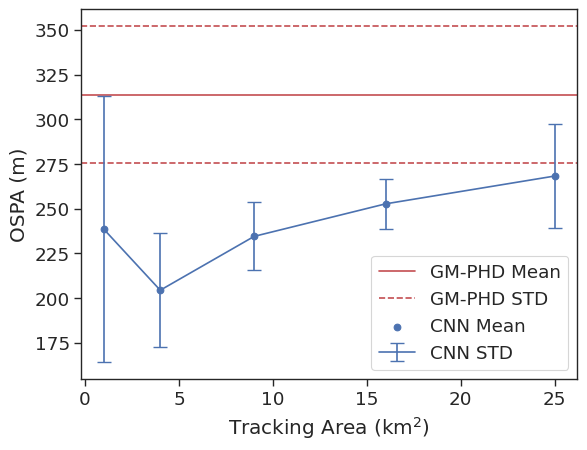

In [13]:
# plot CNN performance generalization
df = pd.DataFrame(
    dict(
        width=[1, 2, 3, 4, 5],
        cnn_mean=[238.45, 204.34, 234.48, 252.68, 268.24],
        cnn_std=[74.40, 31.97, 19.04, 14.05, 29.04],
    )
)
phd_std = 76.58
phd_mean = 313.78

plt.figure()
plt.axhline(phd_mean, color="r", label="GM-PHD Mean")
plt.axhline(phd_mean + phd_std / 2, color="r", linestyle="--", label="GM-PHD STD")
plt.axhline(phd_mean - phd_std / 2, color="r", linestyle="--")
plt.scatter(df.width**2, df.cnn_mean, label="CNN Mean")
plt.errorbar(df.width**2, df.cnn_mean, yerr=df.cnn_std, capsize=5, label="CNN STD")
plt.legend()
plt.xlabel("Tracking Area (km$^2$)")
plt.ylabel("OSPA (m)")
plt.savefig("../figures/transfer.pdf")